# Résolution d’une équation quadratique par Grover
**Crédit Agricole : Ateliers Quantiques 2025**  
Atelier 3 — Partie 2

## Objectif

Nous voulons résoudre l’équation :


$$ (7x^2 + 11x + 5) \bmod 32 = 13 $$ 

- L’espace des solutions est $\{0,1,\dots,31\}$.
- Il nous faut donc **5 qubits** pour représenter $x$.
- Nous allons construire un **oracle quantique** qui marque les états $|x⟩$ satisfaisant cette équation.
- Ensuite, l’algorithme de **Grover** amplifie la probabilité d’obtenir ces états lors de la mesure.


In [20]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

backend = AerSimulator()


## Superposition uniforme

On applique des portes de Hadamard sur les 5 qubits représentant $x$.  
Cela crée l’état :

$$ |\psi_0⟩ = \frac{1}{\sqrt{32}} \sum_{x=0}^{31} |x⟩ $$



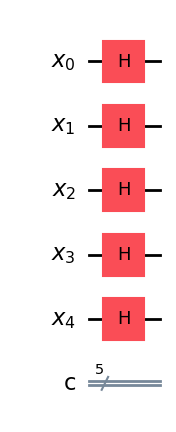

In [21]:
x = QuantumRegister(5, "x")
c = ClassicalRegister(5, "c")

qc = QuantumCircuit(x, c)
qc.h(x)
qc.draw("mpl")


# Oracle pour une équation quadratique

Dans cette partie, nous allons construire un **oracle quantique** qui marque les états $|x⟩$ satisfaisant l’équation suivante :

$$ 7x^2 + 11x + 5 \equiv 13 \pmod{2^n}. $$

---

## Étapes de construction

1. On encode l’entrée $x$ sur $n$ qubits.
2. On calcule **en réversible** la valeur $7x^2 + 11x + 5$ dans un registre de travail.
3. On compare le résultat à $13$ :
   - si égalité, on applique une **inversion de phase** (porte Z contrôlée).
   - sinon, rien ne se passe.
4. On efface (uncompute) le registre de travail pour revenir à l’état initial.

Ainsi, après application de l’oracle $O$, on obtient :

$$ 
O|x⟩ =
\begin{cases}
-|x⟩ & \text{si } 7x^2 + 11x + 5 \equiv 13 \pmod{2^n}, \\
\ \ |x⟩ & \text{sinon.}
\end{cases}
$$

---

## Vérification classique des solutions

Avant de lancer Grover, on peut vérifier **par calcul classique** quels $x$ satisfont l’équation pour $n=5$ (donc $x \in [0,31]$) :

$$
7x^2 + 11x + 5 \equiv 13 \pmod{32}.
$$

Quelques tests :

- Pour $x=1$ : $7\cdot 1^2 + 11\cdot 1 + 5 = 23 \not\equiv 13 \pmod{32}$.
- Pour $x=2$ : $7\cdot 4 + 22 + 5 = 55 \equiv 23 \pmod{32}$, pas solution.
- Pour $x=3$ : $7\cdot 9 + 33 + 5 = 101 \equiv 5 \pmod{32}$, pas solution.
- Pour $x=4$ : $7\cdot 16 + 44 + 5 = 161 \equiv 1 \pmod{32}$, pas solution.
- Pour $x=5$ : $7\cdot 25 + 55 + 5 = 230 \equiv 6 \pmod{32}$, pas solution.

... (on peut continuer avec un petit code Python pour scanner tous les $x$).

---

## Objectif

Une fois l’oracle construit, on utilisera l’algorithme de Grover pour amplifier uniquement les états $|x⟩$ qui sont solutions de cette équation.  
Lors de la mesure, les solutions devraient apparaître avec une probabilité proche de $1$.


In [62]:
def add_constant(qc, reg, c):
    """Ajoute une constante c (X naïfs)."""
    for i in range(len(reg)):
        if (c >> i) & 1:
            qc.x(reg[i])
    return qc

def add_weighted_x(qc, x, w, weight):
    """Ajoute weight * x dans w (naïf, via CX contrôlés)."""
    for k, q in enumerate(x):
        val = weight * (1 << k)
        for i in range(len(w)):
            if ((val >> i) & 1):
                qc.cx(q, w[i])
    return qc

def equals_constant_phaseflip(qc, w, const, anc):
    """Phase flip si w == const."""
    qc.h(anc); qc.z(anc)
    bits = [(const >> i) & 1 for i in range(len(w))]
    for i,b in enumerate(bits):
        if b == 0:
            qc.x(w[i])
    qc.mcx(list(w), anc)
    for i,b in enumerate(bits):
        if b == 0:
            qc.x(w[i])
    qc.z(anc); qc.h(anc)
    return qc

def add_square(qc, x, w, weight=1):
    """Ajoute weight * x^2 dans w (naïf).
       x^2 = Σ_{i,j} 2^(i+j) * x_i * x_j.
       On utilise des Toffoli pour les produits x_i AND x_j.
    """
    n = len(x)
    for i in range(n):
        for j in range(n):
            val = weight * (1 << (i+j))
            for k in range(len(w)):
                if (val >> k) & 1:
                    if i == j:
                        # cas x_i^2 = x_i
                        qc.cx(x[i], w[k])
                    else:
                        # produit croisé x_i * x_j
                        qc.ccx(x[i], x[j], w[k])
    return qc


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister, transpile
from qiskit_aer import AerSimulator
import numpy as np

# --- Oracle (doit retourner un QuantumCircuit, PAS un Gate)
def oracle_quadratic_7x2_plus_11x_plus_5_eq_13(n=5):
    x = QuantumRegister(n, 'x')
    m = 2*n + 4
    w = QuantumRegister(m, 'w')
    a = AncillaRegister(1, 'anc')
    qc = QuantumCircuit(x, w, a, name='O_quad')

    # w <- 7x²
    add_square(qc, x, w, weight=7)
    # w <- w + 11x
    add_weighted_x(qc, x, w, weight=11)
    # w <- w + 5
    add_constant(qc, w, 5)
    # flip de phase si w == 13
    equals_constant_phaseflip(qc, w, const=13, anc=a[0])
    # uncompute
    add_constant(qc, w, 5)
    add_weighted_x(qc, x, w, weight=11)
    add_square(qc, x, w, weight=7)

    return qc



In [63]:
def diffuser(n):
    x = QuantumRegister(n, 'x')
    qc = QuantumCircuit(x, name='D')
    qc.h(x); qc.x(x)
    qc.h(x[-1])
    qc.mcx(list(x[:-1]), x[-1])
    qc.h(x[-1])
    qc.x(x); qc.h(x)
    return qc

def grover_quadratic_example(n=5, iters=None):
    x = QuantumRegister(n, 'x')
    m = 2*n + 4
    w = QuantumRegister(m, 'w')
    a = AncillaRegister(1, 'anc')
    c = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(x, w, a, c)

    # superposition uniforme
    qc.h(x)

    # Construire les sous-circuits
    O_circ = oracle_quadratic_7x2_plus_11x_plus_5_eq_13(n)
    D_circ = diffuser(n)

    # Transpiler les QuantumCircuits
    O_circ_t = transpile(O_circ, basis_gates=['u', 'cx'])
    D_circ_t = transpile(D_circ, basis_gates=['u', 'cx'])

    # Seulement maintenant convertir en Gate
    O_gate = O_circ_t.to_gate(label="O_quad")
    D_gate = D_circ_t.to_gate(label="D")

    # Nombre d’itérations de Grover
    N = 2**n
    k = iters if iters is not None else int(np.floor(np.pi/4*np.sqrt(N)))

    for _ in range(k):
        qc.append(O_gate, x[:] + w[:] + a[:])
        qc.append(D_gate, x[:])

    qc.measure(x, c)
    return qc



In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

# --- Grover quadratic (exemple) ---
qc = grover_quadratic_example(n=5)

# Décomposer toutes les sous-gates pour que Aer les comprenne
qc = qc.decompose(reps=20)

# Simulation
backend = AerSimulator()
result = backend.run(qc, shots=2048).result()
counts = result.get_counts()

# Affichage
print("Résultats bruts :", counts)

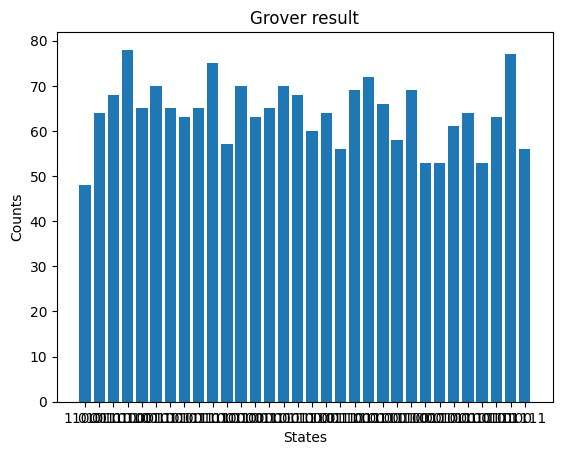

In [59]:
import matplotlib.pyplot as plt

# Suppose you already have counts from Grover:
# counts = result.get_counts()

# Convert dict to lists
states = list(counts.keys())
values = list(counts.values())

# Plot with matplotlib
plt.bar(states, values)
plt.xlabel("States")
plt.ylabel("Counts")
plt.title("Grover result")
plt.show()


/tmp/ipykernel_433/3678778562.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(states, rotation=90)
/tmp/ipykernel_433/3678778562.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(states, rotation=90)


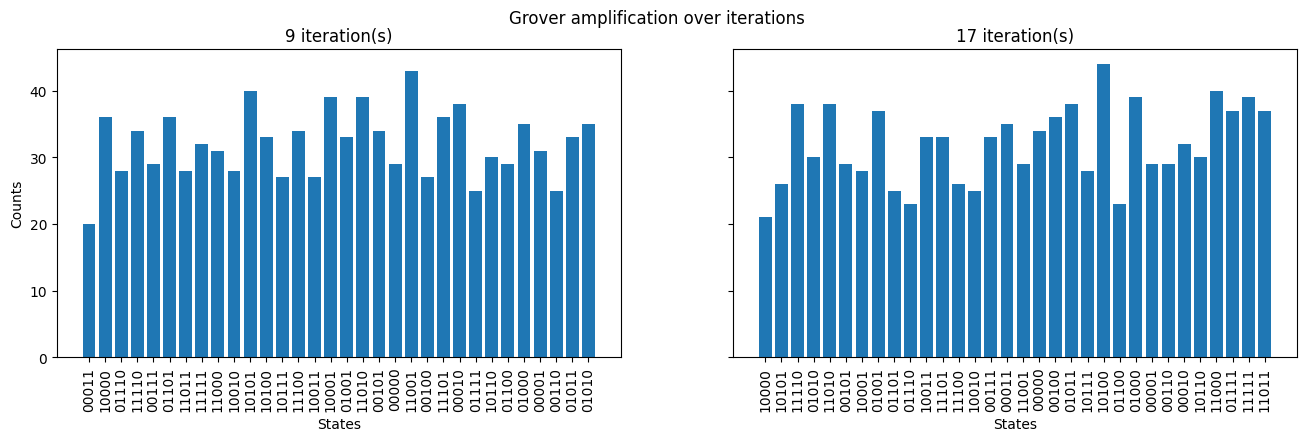

In [60]:
# --- Run Grover with different iterations ---
iters_list = [9, 17]
results_list = []

for k in iters_list:
    qc = grover_quadratic_example(n=5, iters=k)
    qc = qc.decompose(reps=10)  # flatten all gates for Aer
    result = backend.run(qc, shots=1024).result()
    counts = result.get_counts()
    results_list.append(counts)

# --- Plot ---
fig, axes = plt.subplots(1, len(iters_list), figsize=(16, 4), sharey=True)

for ax, counts, k in zip(axes, results_list, iters_list):
    states = list(counts.keys())
    values = list(counts.values())
    ax.bar(states, values)
    ax.set_title(f"{k} iteration(s)")
    ax.set_xticklabels(states, rotation=90)
    ax.set_xlabel("States")

axes[0].set_ylabel("Counts")
plt.suptitle("Grover amplification over iterations")
plt.show()


## Vérification classique

Avant de construire l’oracle, vérifions par calcul classique quelles sont les solutions $x \in \{0,\dots,31\}$.


In [61]:
solutions = []
for x in range(32):
    if (7*x*x + 11*x + 5) % 32 == 13:
        solutions.append(x)

print("Solutions classiques :", solutions)


Solutions classiques : [11, 24]
